In [2]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
# %%capture
!sudo apt-get install openslide-tools
!pip install openslide-python
!pip install wandb

In [1]:
! nvidia-smi

Tue Dec 27 22:10:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    41W / 300W |      0MiB / 16160MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Modelling Notebook 

### This Notebook is the 2nd Notebook of the ADL Project and contains the code to build models used to predict the presence tumor 

#### Name : Prabha Kiranmai Vasireddy
#### UNI : pv2342

#### The Model Training is done on a GCP VM with V100 Nvidia GPU , the Patches generated in the First Notebook are downloaded on the VM.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
# from google.colab import drive
import json 
from tqdm import tqdm
import wandb
from datetime import datetime


### Using WandB

1. wandb (Weights & Biases) is a platform for tracking, analyzing, and visualizing machine learning experiments.
2. It is useful for keeping track of model training and evaluation metrics, as well as any other relevant information such as hyperparameters and hardware specifications.

I wanted to try using wandb, to build visualizations and easily compare different models and make visualizations.


In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pv2342. Use `wandb login --relogin` to force relogin


True

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf 

In [5]:
saving_directory = "/home/ecbm4040/Kiranmai-ADL/data"

print(os.listdir(saving_directory))

['patch_val_3.npy', 'patch_val_5.npy', 'patch5.npy', 'label.npy', 'patch_val_4.npy', 'patch3.npy', 'patch4.npy', 'label_val_.npy']


### Deep Learning Models

We will be building the following 3 Models.

1. Model-1 - Takes only level_3 patch as input 
2. Model-2 - Takes level_3 and level_4 patches as inputs 
3. Model-3 - Takes level_3,level_4 and level_5 as inputs 



In [6]:
X_train_level_3  = np.load(saving_directory + "/patch3.npy")

X_val_level_3  = np.load(saving_directory + "/patch_val_3.npy")

Y_train = np.load(saving_directory + "/label.npy")
Y_train = Y_train.astype(float)
Y_val = np.load(saving_directory + "/label_val_.npy")
Y_val = Y_val.astype(float)

In [7]:
len(X_train_level_3)

4000

In [8]:
BATCH_SIZE = 16


def orthogonal_rot(image):
  rot = np.random.choice([-1, 0, 1,])
  new_image  = np.rot90(image, )
  new_image = tf.image.random_brightness(new_image,64.0/255)
  # new_image = tf.image.random_saturation(new_image,0,0.25,seed=42)
  # new_image = tf.image.random_hue(new_image,0.04,seed=42)
  new_image = tf.image.random_contrast(new_image,0,0.75,seed=42)
  return new_image



train_image_gen = ImageDataGenerator(horizontal_flip = True,
                                      vertical_flip = True,
                                      rescale=1./255,
                                      width_shift_range=(-8, 8),
                                      height_shift_range=(-8, 8),
                                      preprocessing_function=orthogonal_rot) 


val_image_gen = ImageDataGenerator(rescale=1./255)

## Model-1 

Only one level of Input - level_3

In [9]:
def train_image_gen_single_level(X,Y, batch_size = 16, random_seed = 42):
  X = train_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  while True:
    x,y = X.next()
    yield x,y

def val_image_gen_single_level(X,Y, batch_size = 16,random_seed = 42):
  X = val_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  while True:
    x,y = X.next()
    yield x,y


In [10]:
train_gen = train_image_gen_single_level(X_train_level_3, Y_train)
val_gen = val_image_gen_single_level(X_val_level_3, Y_val)

### Model Creation 

In [12]:
def get_model(number_of_images = 1, patch_size = 299):
  assert number_of_images <= 3, "Model defined only for maximum of 3 Zoom Levels"

  visual_extractor_1 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(patch_size, patch_size, 3))
  visual_extractor_1.trainable = False
  model_tower_1 = Sequential()
  model_tower_1.add(visual_extractor_1)
  model_tower_1.add(GlobalAveragePooling2D())
    
  input_tower_1 = Input(shape=(patch_size, patch_size, 3))
  
  encoded_zoom_1 = model_tower_1(input_tower_1)
  
  encoded_array = [encoded_zoom_1]

  if number_of_images >= 2 : 
    
    visual_extractor_2 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))
    visual_extractor_2.trainable = False

    model_tower_2= Sequential()
    model_tower_2.add(visual_extractor_2)
    model_tower_2.add(GlobalAveragePooling2D())
    input_tower_2 = Input(shape=(patch_size, patch_size, 3))
    encoded_zoom_2 = model_tower_2(input_tower_2)
    encoded_array.append(encoded_zoom_2)
  if number_of_images == 3 : 

    visual_extractor_3 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))
    visual_extractor_3.trainable = False   

    model_tower_3= Sequential()
    model_tower_3.add(visual_extractor_3)
    model_tower_3.add(GlobalAveragePooling2D())
    input_tower_3 = Input(shape=(patch_size, patch_size, 3))
    encoded_zoom_3 = model_tower_3(input_tower_3)
    encoded_array.append(encoded_zoom_3)

  if len(encoded_array) == 1 : 
    merged = encoded_zoom_1
  else : 
    merged = concatenate(encoded_array)
  dense1 = Dense(256, activation='relu')(merged)
  drop_layer = Dropout(0.5)(dense1)
  dense2 = Dense(126, activation='relu')(drop_layer)

  output = Dense(1, activation='sigmoid')(dense2)
  input_array = [input_tower_1]
  if number_of_images >= 2 : input_array.append(input_tower_2)
  if number_of_images == 3 : input_array.append(input_tower_3)

  model = Model(inputs=input_array, outputs=output)

  return model
     

In [12]:
model_1 = get_model(number_of_images=1)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 126)               32382     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 127       
Total params: 22,359,837
Trainable params: 557,053
Non-trainable params: 21,802,784
___________________________________________

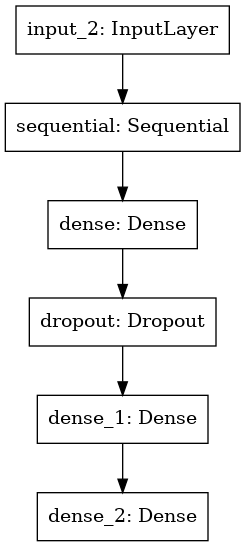

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file='model_1.png')

In [15]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [17]:
# Checking if the model defined and the losses are correct. 

images,labels = next(iter(train_gen))
for epoch in range(1,60):
  metrics = model_1.train_on_batch(x = images, y = labels)
  if epoch%10==0 : print(f"Epoch:{epoch}, Metrics ==>Loss value : {metrics[0]}, Accuracy value : {metrics[1]}, Precision value : {metrics[2]}, Recall value : {metrics[3]}")

Epoch:10, Metrics ==>Loss value : 0.4531228542327881, Accuracy value : 0.9375, Precision value : 0.8999999761581421, Recall value : 1.0
Epoch:20, Metrics ==>Loss value : 0.3633027672767639, Accuracy value : 0.9375, Precision value : 0.8999999761581421, Recall value : 1.0
Epoch:30, Metrics ==>Loss value : 0.22821778059005737, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:40, Metrics ==>Loss value : 0.12399006634950638, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:50, Metrics ==>Loss value : 0.10654446482658386, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0


### Setup Callbacks 

We will be using 4 Callbacks 

1. Checkpoint Callback
2. Early Stopping with Val Accuracy 
3. LR Scheduling - Reduce_LR_on_Plateau with Val Accuracy 
4. Wandb Callback for Experiment Tracking 

In [13]:
def get_checkpoint(model_name):
  model_directory = "/home/ecbm4040/Kiranmai-ADL/checkpoints"

  # CHECKPOINT CALLBACK
  model_directory = os.path.join(model_directory,model_name)

  if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    
  model_path = os.path.join(model_directory, "weights-{epoch:02d}-{val_accuracy:.2f}.hdf5")
  
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,save_weights_only=True, monitor='val_accuracy', verbose=0)

  # EARLY STOPPING 
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,mode='max',verbose=1,restore_best_weights=False)

  # REDUCE LR ON PLATEAU
  reduce_lr_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3, verbose=0, mode='auto', min_delta=0.0001 )

  # wandb logging
  project_name = "Applied_DL_Project"
  now = datetime.now()
  date_string = now.strftime("%m_%d_%H_%M")
  run_name = f"{model_name}_{date_string}"
  wandb.init(project=project_name,name=run_name)
  wandb_callback = wandb.keras.WandbCallback()
  
  return [checkpoint_callback,reduce_lr_on_plateau_callback,wandb_callback]
  return [checkpoint_callback,early_stopping_callback,reduce_lr_on_plateau_callback,wandb_callback]



In [ ]:
train_gen = train_image_gen_single_level(X_train_level_3, Y_train)
val_gen = val_image_gen_single_level(X_val_level_3, Y_val)

model_1 = get_model(number_of_images=1)
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

callbacks_array = get_checkpoint("Inceptionv3_single_patch")

history = model_1.fit(train_gen,
                                  epochs=25,
                                  validation_data=val_gen, 
                                  steps_per_epoch = len(X_train_level_3) / BATCH_SIZE, 
                                  validation_steps=len(X_val_level_3) / BATCH_SIZE, 
                                  callbacks = callbacks_array)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25
250/250 [==============================] - 80s 306ms/step - loss: 0.6224 - accuracy: 0.6426 - precision_1: 0.6420 - recall_1: 0.6703 - val_loss: 0.6058 - val_accuracy: 0.6340 - val_precision_1: 0.6925 - val_recall_1: 0.4820
INFO:tensorflow:Assets written to: /home/ecbm4040/Kiranmai-ADL/wandb/run-20221224_074813-1h8kfrzh/files/model-best/assets


wandb: Adding directory to artifact (/home/ecbm4040/Kiranmai-ADL/wandb/run-20221224_074813-1h8kfrzh/files/model-best)... Done. 0.6s


Epoch 2/25
250/250 [==============================] - 74s 295ms/step - loss: 0.4582 - accuracy: 0.7913 - precision_1: 0.7721 - recall_1: 0.8235 - val_loss: 0.6568 - val_accuracy: 0.6290 - val_precision_1: 0.6745 - val_recall_1: 0.5099
Epoch 3/25
250/250 [==============================] - 74s 296ms/step - loss: 0.3864 - accuracy: 0.8291 - precision_1: 0.8230 - recall_1: 0.8399 - val_loss: 0.6535 - val_accuracy: 0.6740 - val_precision_1: 0.7285 - val_recall_1: 0.5464
Epoch 4/25
250/250 [==============================] - 74s 297ms/step - loss: 0.3507 - accuracy: 0.8447 - precision_1: 0.8377 - recall_1: 0.8502 - val_loss: 0.7906 - val_accuracy: 0.6830 - val_precision_1: 0.7737 - val_recall_1: 0.5101
Epoch 5/25
250/250 [==============================] - 74s 296ms/step - loss: 0.3126 - accuracy: 0.8672 - precision_1: 0.8582 - recall_1: 0.8863 - val_loss: 0.7450 - val_accuracy: 0.6640 - val_precision_1: 0.6998 - val_recall_1: 0.5674
Epoch 6/25
250/250 [==============================] - 74s 29

In [ ]:
wandb.finish()

## Model - 2 

In [10]:
# X_train_level_3  = np.load(saving_directory + "/patch3.npy")
X_train_level_4  = np.load(saving_directory + "/patch4.npy")
# # X_train_level_5  = np.load(saving_directory + "/patch5.npy")


# X_val_level_3  = np.load(saving_directory + "/patch_val_3.npy")
X_val_level_4  = np.load(saving_directory + "/patch_val_4.npy")
# # X_val_level_5  = np.load(saving_directory + "/patch_val_5.npy")

# Y_train = np.load(saving_directory + "/label.npy")
# Y_train = Y_train.astype(float)
# Y_val = np.load(saving_directory + "/label_val_.npy")
# Y_val = Y_val.astype(float)

In [11]:
BATCH_SIZE = 16


def orthogonal_rot(image,seed):
  rot = tf.random.categorical([-1, 0, 1,],seed=seed)
  new_image  = np.rot90(image,rot)
  new_image = tf.image.stateless_random_brightness(new_image,64.0/255,seed=seed)
  new_image = tf.image.random_contrast(new_image,0,0.75,seed=seed)
  return new_image



train_image_gen = ImageDataGenerator(horizontal_flip = True,
                                      vertical_flip = True,
                                      rescale=1./255,
                                      width_shift_range=(-8, 8),
                                      height_shift_range=(-8, 8),
                                      preprocessing_function=None) 


val_image_gen = ImageDataGenerator(rescale=1./255)

In [12]:
def train_image_gen_two_levels(X,X_z,Y, batch_size = 16, random_seed = 42):
  X = train_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  X_z = train_image_gen.flow(X_z, seed = random_seed, batch_size=batch_size)
  while True:
    x,y = X.next()
    x_z = X_z.next()
    yield (x,x_z),y

def val_image_gen_two_levels(X,X_z,Y, batch_size = 16,random_seed = 42):
  X = val_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  X_z = val_image_gen.flow(X_z, seed = random_seed, batch_size=batch_size)
  while True:
    x,y = X.next()
    x_z = X_z.next()
    yield (x,x_z),y


In [13]:
train_gen = train_image_gen_two_levels(X_train_level_3,X_train_level_4, Y_train,)
val_gen = val_image_gen_two_levels(X_val_level_3,X_val_level_4,Y_val,)

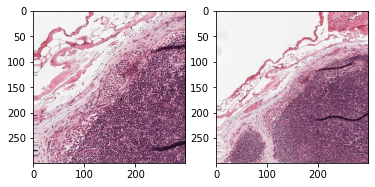

In [14]:
for (x,x_z),y in train_gen:
  plt.subplot(1, 2, 1)
  plt.imshow(x[3])
  plt.subplot(1, 2, 2)
  plt.imshow(x_z[3])
  break

### Model Creation  - Model 2

In [15]:
model_2 = get_model(number_of_images=2)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         21802784    input_4[0][0]                    
______________________________________________________________________________________________

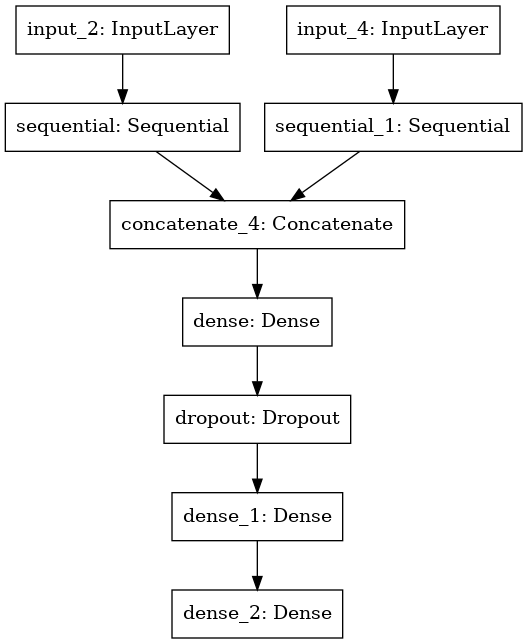

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, to_file='model_2.png')

In [17]:
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [18]:
images,labels = next(iter(train_gen))


for epoch in range(1,60):
  metrics = model_2.train_on_batch(x = images, y = labels)
  if epoch%5==0 : print(f"Epoch:{epoch}, Metrics ==>Loss value : {metrics[0]}, Accuracy value : {metrics[1]}, Precision value : {metrics[2]}, Recall value : {metrics[3]}")

Epoch:5, Metrics ==>Loss value : 0.5216351747512817, Accuracy value : 0.75, Precision value : 0.800000011920929, Recall value : 0.5714285969734192
Epoch:10, Metrics ==>Loss value : 0.38717058300971985, Accuracy value : 0.9375, Precision value : 1.0, Recall value : 0.8571428656578064
Epoch:15, Metrics ==>Loss value : 0.26014888286590576, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:20, Metrics ==>Loss value : 0.19909259676933289, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:25, Metrics ==>Loss value : 0.1160508319735527, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:30, Metrics ==>Loss value : 0.06333395838737488, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:35, Metrics ==>Loss value : 0.0766095370054245, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:40, Metrics ==>Loss value : 0.04412584379315376, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoc

In [20]:
model_2 = get_model(number_of_images=2)

model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

callbacks_array = get_checkpoint("Inceptionv3_two_patch")

history = model_2.fit(train_gen,
                                  epochs=25,
                                  validation_data=val_gen, 
                                  steps_per_epoch = len(X_train_level_3) / BATCH_SIZE, 
                                  validation_steps=len(X_val_level_3) / BATCH_SIZE, 
                                  callbacks = callbacks_array)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25
250/250 [==============================] - 143s 545ms/step - loss: 0.5812 - accuracy: 0.6850 - precision_1: 0.6779 - recall_1: 0.7122 - val_loss: 0.7044 - val_accuracy: 0.6330 - val_precision_1: 0.6822 - val_recall_1: 0.4980
INFO:tensorflow:Assets written to: /home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_193037-3h8ef5mg/files/model-best/assets


wandb: Adding directory to artifact (/home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_193037-3h8ef5mg/files/model-best)... Done. 1.3s


Epoch 2/25
250/250 [==============================] - 130s 523ms/step - loss: 0.3331 - accuracy: 0.8650 - precision_1: 0.8736 - recall_1: 0.8584 - val_loss: 0.8486 - val_accuracy: 0.6420 - val_precision_1: 0.7417 - val_recall_1: 0.4444
Epoch 3/25
250/250 [==============================] - 131s 525ms/step - loss: 0.2264 - accuracy: 0.9171 - precision_1: 0.9145 - recall_1: 0.9215 - val_loss: 0.9746 - val_accuracy: 0.6730 - val_precision_1: 0.8189 - val_recall_1: 0.4375
Epoch 4/25
250/250 [==============================] - 130s 523ms/step - loss: 0.1981 - accuracy: 0.9206 - precision_1: 0.9225 - recall_1: 0.9190 - val_loss: 0.8448 - val_accuracy: 0.6600 - val_precision_1: 0.7549 - val_recall_1: 0.4657
Epoch 5/25
250/250 [==============================] - 132s 528ms/step - loss: 0.1477 - accuracy: 0.9506 - precision_1: 0.9517 - recall_1: 0.9515 - val_loss: 1.3509 - val_accuracy: 0.7030 - val_precision_1: 0.9386 - val_recall_1: 0.4306
Epoch 6/25
250/250 [==============================] - 13

In [21]:
wandb.finish()

accuracy,▁▅▆▆▇▇▇▇▇▇▇▇█▇███████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████▂▂▂▁▁▁▁▁▁▁
precision_1,▁▅▆▆▇▇▇▇▇▇▇▇▇▇███████████
recall_1,▁▅▆▆▇▇▇▇▇▇▇▇█▇███████████
val_accuracy,▁▂▄▃▆▇▅▆▇▆▇█▅▆▇▇▆▇▇▆█▆▇▇▇
val_loss,▁▂▃▂▅▅▃▄▃▃█▆▇▇▇▇▆▇▆▇▆▇▇▆▇
val_precision_1,▁▂▄▃▇█▄▅▅▆█▇▆▅▇█▆▇▇▇▇▇▇▇▇
val_recall_1,▇▃▂▄▁▃█▃█▄▂▄▂▄▃▃▃▂▄▂▅▁▄▃▄
accuracy,0.9885


In [22]:
model_2.save("Inceptionv3_two_patch_12_27_19_30.h5")

### Model 3

In [6]:
X_train_level_3  = np.load(saving_directory + "/patch3.npy")
X_train_level_4  = np.load(saving_directory + "/patch4.npy")
X_train_level_5  = np.load(saving_directory + "/patch5.npy")


X_val_level_3  = np.load(saving_directory + "/patch_val_3.npy")
X_val_level_4  = np.load(saving_directory + "/patch_val_4.npy")
X_val_level_5  = np.load(saving_directory + "/patch_val_5.npy")

Y_train = np.load(saving_directory + "/label.npy")
Y_train = Y_train.astype(float)
Y_val = np.load(saving_directory + "/label_val_.npy")
Y_val = Y_val.astype(float)

In [7]:
BATCH_SIZE = 16

def orthogonal_rot(image,seed):
  rot = tf.random.categorical([-1, 0, 1,],seed=seed)
  new_image  = np.rot90(image,rot)
  new_image = tf.image.stateless_random_brightness(new_image,64.0/255,seed=seed)
  # new_image = tf.image.random_saturation(new_image,0,0.25,seed=42)
  # new_image = tf.image.random_hue(new_image,0.04,seed=42)
  new_image = tf.image.random_contrast(new_image,0,0.75,seed=seed)
  return new_image



train_image_gen = ImageDataGenerator(horizontal_flip = True,
                                      vertical_flip = True,
                                      rescale=1./255,
                                      width_shift_range=(-8, 8),
                                      height_shift_range=(-8, 8),
                                      preprocessing_function=None) 


val_image_gen = ImageDataGenerator(rescale=1./255)

In [8]:
def train_image_gen_three_levels(X,X_z,X_zz,Y, batch_size = 16, random_seed = 42):
  X = train_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  X_z = train_image_gen.flow(X_z, seed = random_seed, batch_size=batch_size)
  X_zz = train_image_gen.flow(X_zz, seed = random_seed, batch_size=batch_size)
  while True:
    x,y = X.next()
    x_z = X_z.next()
    x_zz = X_zz.next()
    yield (x,x_z,x_zz),y

def val_image_gen_three_levels(X,X_z,X_zz,Y, batch_size = 16,random_seed = 42):
  X = val_image_gen.flow(X,Y, seed = random_seed, batch_size=batch_size)
  X_z = val_image_gen.flow(X_z, seed = random_seed, batch_size=batch_size)
  X_zz = val_image_gen.flow(X_zz, seed = random_seed, batch_size=batch_size)

  while True:
    x,y = X.next()
    x_z = X_z.next()
    x_zz = X_zz.next()
    yield (x,x_z,x_zz),y


In [9]:
def unison_shuffled_copies(X_train_level_3,X_train_level_4,X_train_level_5, Y_train):
    assert len(X_train_level_3) == len(X_train_level_4)
    assert len(X_train_level_3) == len(X_train_level_5)
    assert len(X_train_level_3) == len(Y_train)
    p = np.random.permutation(len(X_train_level_3))
    return X_train_level_3[p], X_train_level_4[p], X_train_level_5[p],Y_train[p]

X_train_level_3,X_train_level_4,X_train_level_5, Y_train = unison_shuffled_copies(X_train_level_3,X_train_level_4,X_train_level_5, Y_train)

In [10]:
train_gen = train_image_gen_three_levels(X_train_level_3,X_train_level_4,X_train_level_5, Y_train,)
val_gen = val_image_gen_three_levels(X_val_level_3,X_val_level_4,X_val_level_5,Y_val,)

### Model Creation - Model 3

In [12]:
model_3 = get_model(number_of_images=3)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_2[0][0]                    
______________________________________________________________________________________________

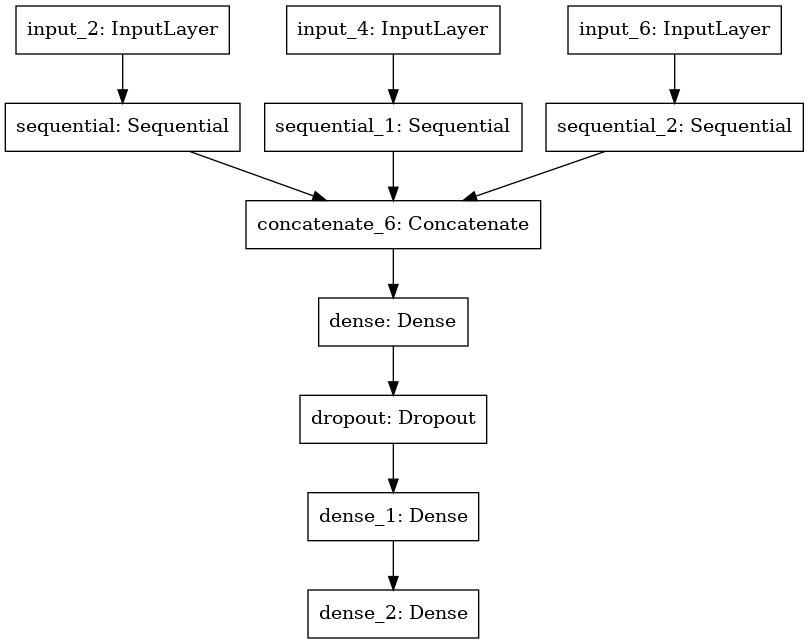

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, to_file='model_3.png')

In [14]:
model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [15]:
images,labels = next(iter(train_gen))


for epoch in range(1,60):
  metrics = model_3.train_on_batch(x = images, y = labels)
  if epoch%5==0 : print(f"Epoch:{epoch}, Metrics ==>Loss value : {metrics[0]}, Accuracy value : {metrics[1]}, Precision value : {metrics[2]}, Recall value : {metrics[3]}")

Epoch:5, Metrics ==>Loss value : 0.5772087574005127, Accuracy value : 0.75, Precision value : 0.8571428656578064, Recall value : 0.6666666865348816
Epoch:10, Metrics ==>Loss value : 0.30243557691574097, Accuracy value : 0.875, Precision value : 0.8181818127632141, Recall value : 1.0
Epoch:15, Metrics ==>Loss value : 0.1727336198091507, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:20, Metrics ==>Loss value : 0.19110341370105743, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:25, Metrics ==>Loss value : 0.10751129686832428, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:30, Metrics ==>Loss value : 0.05784449353814125, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:35, Metrics ==>Loss value : 0.036125440150499344, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Epoch:40, Metrics ==>Loss value : 0.03984886407852173, Accuracy value : 1.0, Precision value : 1.0, Recall value : 1.0
Ep

In [17]:
model_3 = get_model(number_of_images=3)

model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

callbacks_array = get_checkpoint("Inceptionv3_three_patch")

history = model_3.fit(train_gen,
                                  epochs=25,
                                  validation_data=val_gen, 
                                  steps_per_epoch = len(X_train_level_3) / BATCH_SIZE, 
                                  validation_steps=len(X_val_level_3) / BATCH_SIZE, 
                                  callbacks = callbacks_array)

accuracy,▁
epoch,▁
loss,▁
lr,▁
precision,▁
recall,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁
accuracy,0.77375


Epoch 1/25
250/250 [==============================] - 211s 805ms/step - loss: 0.8367 - accuracy: 0.6564 - precision_1: 0.6509 - recall_1: 0.6723 - val_loss: 0.7874 - val_accuracy: 0.6390 - val_precision_1: 0.7563 - val_recall_1: 0.4187
INFO:tensorflow:Assets written to: /home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_221752-1454rswm/files/model-best/assets


wandb: Adding directory to artifact (/home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_221752-1454rswm/files/model-best)... Done. 2.2s


Epoch 2/25
250/250 [==============================] - 193s 774ms/step - loss: 0.3603 - accuracy: 0.8504 - precision_1: 0.8519 - recall_1: 0.8574 - val_loss: 1.1090 - val_accuracy: 0.6220 - val_precision_1: 0.6766 - val_recall_1: 0.4556
Epoch 3/25
250/250 [==============================] - 192s 770ms/step - loss: 0.2656 - accuracy: 0.8884 - precision_1: 0.8727 - recall_1: 0.9074 - val_loss: 1.1211 - val_accuracy: 0.6470 - val_precision_1: 0.7407 - val_recall_1: 0.4435
Epoch 4/25
250/250 [==============================] - 193s 774ms/step - loss: 0.2271 - accuracy: 0.8918 - precision_1: 0.8643 - recall_1: 0.9240 - val_loss: 0.6810 - val_accuracy: 0.6190 - val_precision_1: 0.6716 - val_recall_1: 0.4567
INFO:tensorflow:Assets written to: /home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_221752-1454rswm/files/model-best/assets


wandb: Adding directory to artifact (/home/ecbm4040/Kiranmai-ADL/wandb/run-20221227_221752-1454rswm/files/model-best)... Done. 2.3s


Epoch 5/25
250/250 [==============================] - 193s 773ms/step - loss: 0.2356 - accuracy: 0.8816 - precision_1: 0.9164 - recall_1: 0.8387 - val_loss: 1.1216 - val_accuracy: 0.7000 - val_precision_1: 0.9080 - val_recall_1: 0.4504
Epoch 6/25
250/250 [==============================] - 192s 773ms/step - loss: 0.2208 - accuracy: 0.9096 - precision_1: 0.9275 - recall_1: 0.8886 - val_loss: 0.8295 - val_accuracy: 0.6740 - val_precision_1: 0.8297 - val_recall_1: 0.4508
Epoch 7/25
250/250 [==============================] - 193s 775ms/step - loss: 0.2249 - accuracy: 0.9062 - precision_1: 0.9310 - recall_1: 0.8803 - val_loss: 1.2364 - val_accuracy: 0.6770 - val_precision_1: 0.8087 - val_recall_1: 0.4534
Epoch 8/25
250/250 [==============================] - 192s 771ms/step - loss: 0.2037 - accuracy: 0.9020 - precision_1: 0.9337 - recall_1: 0.8674 - val_loss: 1.1640 - val_accuracy: 0.6910 - val_precision_1: 0.8470 - val_recall_1: 0.4722
Epoch 9/25
250/250 [==============================] - 19

In [18]:
wandb.finish()

accuracy,▁▅▅▆▆▆▆▆▇▇███████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
precision_1,▁▅▅▅▆▆▇▇▇████████████████
recall_1,▁▄▆▆▅▆▅▅▇▇███████████████
val_accuracy,▂▁▃▁▇▅▅▆▆▆▇▅▆▅▆▆▆▆▆█▆▆▆▆▆
val_loss,▂▄▄▁▄▂▅▅▅▆▆▇▇▆▇▇█▇█▇██▇██
val_precision_1,▄▁▃▁█▆▅▆▆█▇▆▆▆█▇▇▇▇█▆▇▇▇▇
val_recall_1,▁▅▄▆▅▅▅▇▆▃▇▄▅▇▅▄▄▇▄█▂▆▅▆▅
accuracy,0.96425


In [19]:
model_3.save("Inceptionv3_three_patch_12_27_22_00.h5")